# DISTRIBUITED ALGORITHMS - K-MEANS||

Project for the Physics of Data course Management and Analysis of Physics Dataset mod.B, academic year 2024-2025.

In [103]:
#Libraries used
import dask
import dask.array as da
from dask.distributed import Client
from dask_ml.preprocessing import StandardScaler
from dask_ml.cluster import KMeans
import numpy as np
from dask_ml.metrics import pairwise_distances
from dask_ml.metrics import pairwise_distances_argmin_min
from time import time
from timeit import default_timer as timer
from dask_ml.datasets import make_blobs
import pandas as pd
from dask.distributed import SSHCluster
import matplotlib.pyplot as plt
import pickle
import numba

In [104]:
from dask.distributed import SSHCluster, Client

VM_IPS = ['10.67.22.253','10.67.22.93','10.67.22.68','10.67.22.80']

cluster = SSHCluster(
    hosts=VM_IPS,  # first host becomes scheduler by default
    connect_options={
        "username": "ubuntu",
        "client_keys": ["/home/ubuntu/MAPDB-13.pem"],  # key path ON 10.67.22.253
        "known_hosts": None,   # accept unknown keys (fine in a trusted subnet)
        "connect_timeout": 30,
    },
    scheduler_options={
#        "host": "10.67.22.253",   # advertise scheduler on this VM's IP
        "port": 8786,
        "dashboard_address": 8787,
    },
    worker_options={
        "n_workers": 1,
        "nthreads": 4,
        "memory_limit": "7.8GB",
    },
)

#client = Client(cluster)
#client

2025-08-23 17:44:14,212 - distributed.deploy.ssh - INFO - 2025-08-23 17:44:14,211 - distributed.scheduler - INFO - State start
2025-08-23 17:44:14,218 - distributed.deploy.ssh - INFO - 2025-08-23 17:44:14,216 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.253:8786
2025-08-23 17:44:14,982 - distributed.deploy.ssh - INFO - 2025-08-23 17:44:14,982 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.68:45773'
2025-08-23 17:44:15,014 - distributed.deploy.ssh - INFO - 2025-08-23 17:44:15,020 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.93:44711'
2025-08-23 17:44:15,016 - distributed.deploy.ssh - INFO - 2025-08-23 17:44:15,022 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.80:39199'
2025-08-23 17:44:15,275 - distributed.deploy.ssh - INFO - 2025-08-23 17:44:15,274 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-cbe_k_32', purging
2025-08-23 17:44:15,288 - distr

In [107]:
# Connect the Dask client to the existing cluster using the scheduler's address
#client = Client("tcp://localhost:8786")
client = Client(cluster)

# Print the cluster configuration
scheduler_info = client.scheduler_info()
workers_info = scheduler_info['workers'] 
# Get the information for the first worker in the cluster
worker = list(workers_info.values())[0]
n_workers = len(workers_info)
n_threads = worker['nthreads']

print(f'client dashboard link: {client.dashboard_link}')
print(f"Cluster setup with {n_workers} workers, each with {n_threads} threads")
client

client dashboard link: http://10.67.22.253:8787/status
Cluster setup with 3 workers, each with 4 threads


<Client: 'tcp://10.67.22.253:8786' processes=3 threads=12, memory=21.79 GiB>

In [108]:
# import the dask distributed client
from dask.distributed import Client

# instantiate the client by providing 
# the address:port of the scheduler
#client = Client('dask-scheduler:8786')

# inspect the client
client

<Client: 'tcp://10.67.22.253:8786' processes=3 threads=12, memory=21.79 GiB>

## K-means||

The K-Means method is widely used for unsupervised clustering tasks. One common technique for weight initialization in K-Means is known as K-Means++, though it is primarily a sequential algorithm. A scalable version, referred to as K-Means∥, is introduced and described in detail in the paper available at https://arxiv.org/pdf/1203.6402.

Parallel K-Means enhances the K-Means++ algorithm by distributing computations across multiple processors, which speeds up the clustering of large datasets. This approach allows for efficient scaling and faster convergence. The proposed method focuses on improving the initialization procedure and then employs Lloyd's scalable algorithm.
Below, we explain the algorithm for the initialization phase of Parallel K-Means (which uses K-Means++) and Lloyd's algorithm.

In [109]:
def phi(X,C):
    return pairwise_distances(X, C, metric='sqeuclidean').min(1).sum() 
    # Compute the sum of distances to the nearest centroid at axis=1
    
def kmeans_parallel_init_dask(X, k, l):
    # Step 1: Randomly select a point from X
    n, d = X.shape
    idx = np.random.choice(n, size=1)
    C = X[idx].compute()  # Collect to memory for use

    # Step 2: Compute φX(C)
    phi_X_C = phi(X, C).compute() # Compute the sum of distances to the nearest centroid

    # Steps 3-6: Repeat O(log φX(C)) times
    rounds = int(np.log(phi_X_C))
    #print(f"Begin centroid sampling with number of rounds: {rounds}")
    for _ in range(rounds):
        dist_sq = pairwise_distances(X, C, metric='sqeuclidean').min(1)
        dist_sum = dist_sq.sum()
        p_x = l * dist_sq / dist_sum
        samples = da.random.uniform(size=len(p_x), chunks=p_x.chunks) < p_x
        sampled_idx = da.where(samples)[0].compute()
        
        new_C = X[sorted(sampled_idx)].compute() #https://github.com/dask/dask-ml/issues/39
        C = np.vstack((C, new_C))

    # Step 7: Compute weights
    dist_to_C = pairwise_distances(X, C, metric='euclidean')
    closest_C = da.argmin(dist_to_C, axis=1)

    weights = np.empty(len(C))
    counts = da.bincount(closest_C, minlength=len(C)).compute()
    weights[:len(counts)] = counts
    
    # Normalize weights so that they sum up to the number of centroids
    weight_sum = np.sum(weights)
    if weight_sum == 0:
        raise ValueError("Sum of weights is zero, cannot normalize.")
    
    weights_normalized = weights / weight_sum
    
    dask_C = da.from_array(C, chunks=(C.shape[0], C.shape[1])) # here we ensure that the re-clustering occurs on a single-thread

    # Step 8: Recluster the weighted points in C into k clusters
    #print("Begin centroid re-clustering")
    labels, centroids = lloyd_kmeans_plusplus(X=dask_C, weights=weights_normalized,k=k, max_iters=10, tol=1e-8)

    return centroids

In [110]:
def update_centroids_weighted(X, labels, weights, k):
    """
    Update the centroids by computing the weighted mean of the points assigned to each cluster.
    """
    centroids = []
    
    for i in range(k):
        # Select the points that are assigned to cluster i
        cluster_points = X[labels == i]
        
        # Select the corresponding weights for these points
        cluster_weights = weights[labels == i]
        
        if len(cluster_points) == 0:
            # If no points are assigned to this cluster, avoid division by zero
            # Continue without updating that centroid
            continue

        # Compute the weighted mean using dask.array.average
        weighted_mean = da.average(cluster_points, axis=0, weights=cluster_weights)
        
        # Append the computed weighted mean to the centroids list
        centroids.append(weighted_mean)
    
    # Convert centroids list to Dask array
    return da.stack(centroids)

def kmeans_plusplus_init(X, weights, k):
    '''
    K-means++ initialization to select k initial centroids from X as a numpy array, keeping C as a NumPy array and weighting by provided weights.
    '''
    n, d = X.shape
    # Step 1: Randomly select the first centroid
    idx = np.random.choice(n, size=1)
    C = X[idx].compute()

    for _ in range(1, k):
        # Step 2: Compute distances from each point to the nearest centroid
        # C is a NumPy array, X is a Dask array
        # Compute the distances from each point to the nearest centroid normalizing by weights
        distances = pairwise_distances(X, C, metric='sqeuclidean').min(1) * (weights)
        
        # Compute the probabilities for choosing each point
        probabilities = distances / distances.sum()
        
        # Sample a new point based on these probabilities
        new_idx = np.random.choice(n, size=1, p=probabilities)
        new_centroid = X[sorted(new_idx)].compute()
        
        # Add the new centroid to the list
        C = np.vstack((C, new_centroid))
    return C

def lloyd_kmeans_plusplus(X, weights, k, max_iters=100, tol=1e-8):
    """
    Lloyd's algorithm for k-means clustering using Dask weighting the mean to update centroids.
    """
    centroids = kmeans_plusplus_init(X, weights, k)

    for i in range(max_iters):
        labels = assign_clusters(X, centroids).compute()
        new_centroids = update_centroids_weighted(X, labels, weights=weights, k=k).compute()
        
        if da.allclose(centroids, new_centroids, atol=tol).compute():
            #print(f"Centroid Lloyd Converged after {i+1} iterations.")
            break
        
        centroids = new_centroids

    return labels, centroids

In [111]:
def assign_clusters(X, centroids):
    """
    Assign each point to the nearest centroid using Dask to parallelize the computation.
    """
    return pairwise_distances_argmin_min(X, centroids, metric='sqeuclidean')[0]


def update_centroids(X, labels, k):
    """
    Update the centroids by computing the mean of the points assigned to each cluster with Dask.
    """
    centroids = da.stack([X[labels == i].mean(axis=0) for i in range(k)])
    return centroids
    
def kmeans_parallel(X, k, max_iters=100, tol=1e-8, l=2):
    centroids = kmeans_parallel_init_dask(X, k, l)
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k).compute()

        if da.allclose(centroids, new_centroids, atol=tol):
            #print(f"Main KMeans Converged after {i+1} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

## Test custom implementation on a syntetic dataset

In [112]:
# ==============================
# Generazione dataset sintetico
# ==============================

N=100000 #number of points
k=4 # number of centers
n_feat= 5000 #number of features
seed=42

Target= 200 # target (MB) per chunck
B=8 #bytes per element
rows_per_chunk = int((Target * 1024 * 1024) / (n_feat * B))  #check !!!!!!!!!!
chunks = (rows_per_chunk,n_feat)  # row-wise chucnking, do not divide the features

def generate_data(N=N, k=k, dim=n_feat, random_state=seed,chunks=chunks):
    X, y = make_blobs(n_samples=N, centers=k, n_features=dim, random_state=random_state, chunks=chunks) #synthetic data, true label
    return X, y

In [113]:
#Generate synthetic dataset
data, labels=generate_data()

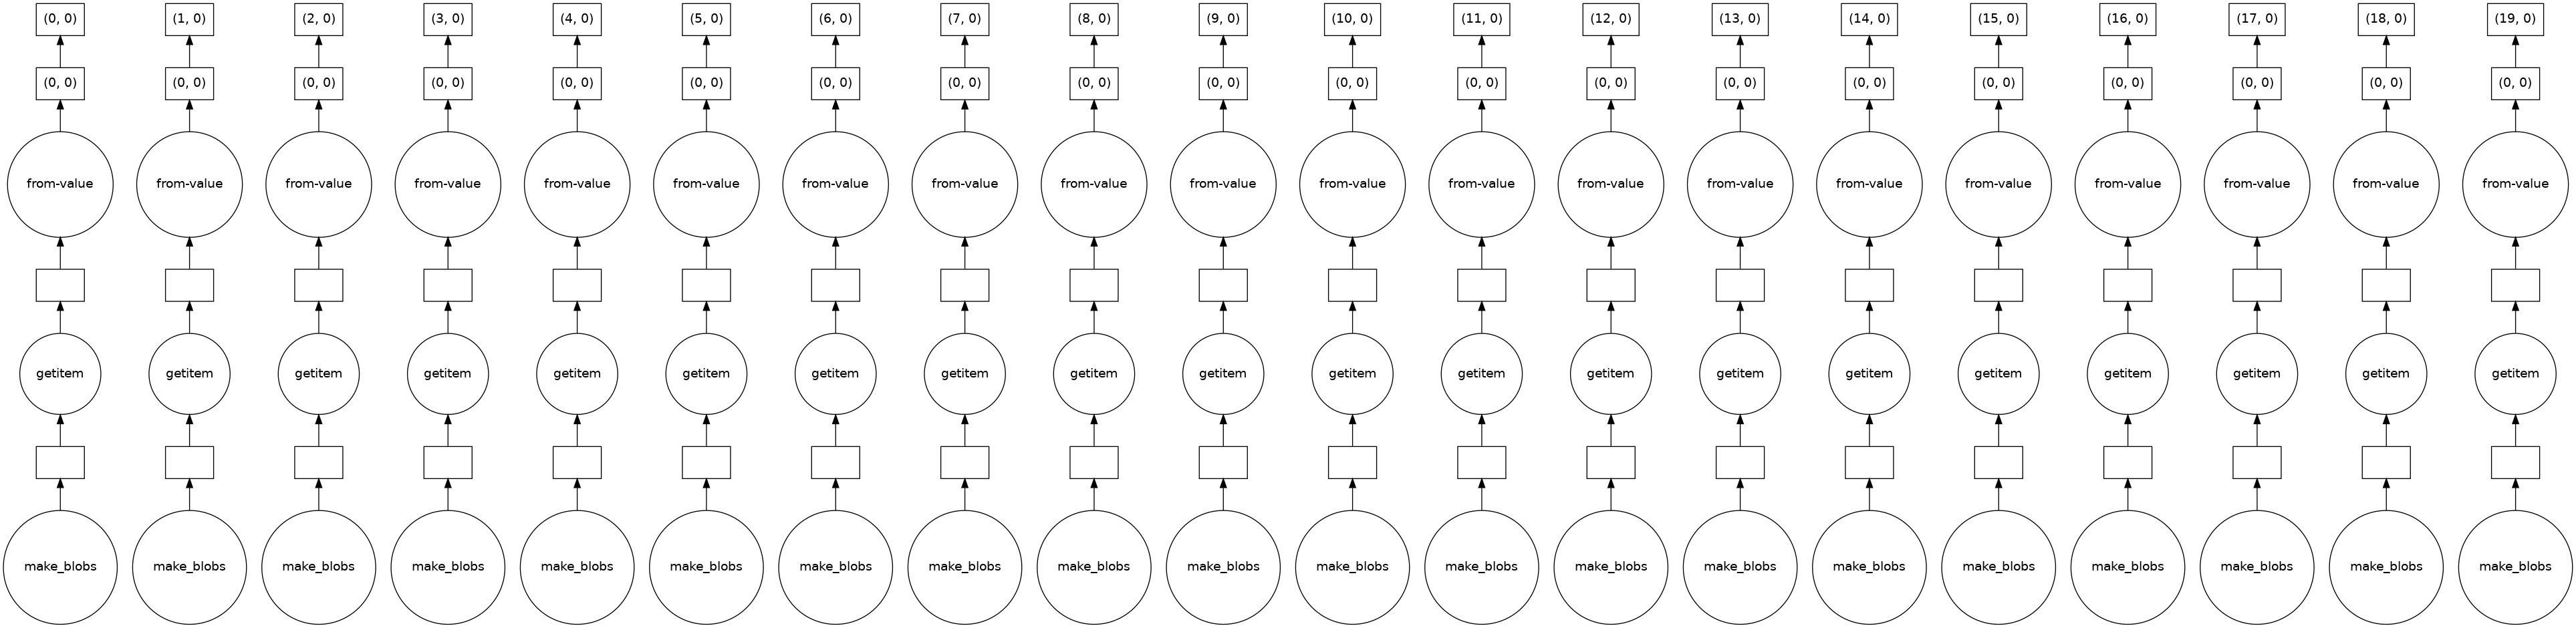

In [114]:
#Visualize the associated computational graph
data.visualize()

In [115]:
#Inspect the data
data.persist()

dask.array<concatenate, shape=(100000, 5000), dtype=float64, chunksize=(5242, 5000), chunktype=numpy.ndarray>

In [116]:
# Normalize the data before clustering

# X_sparse: dask.array of sparse blocks (e.g. scipy.sparse.csr in each chunk, or sparse.COO)
"""
scaler = StandardScaler(with_mean=False, with_std=True)
data_scaled = scaler.fit_transform(data)
del data
"""

mean = data.mean(axis=0, split_every=8)
std  = data.std(axis=0,  ddof=1, split_every=8)
data_normalized = ((data - mean) / std)
del data

"""
scaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix
%time data_normalized = scaler.fit_transform(data)
del data
"""

'\nscaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix\n%time data_normalized = scaler.fit_transform(data)\ndel data\n'

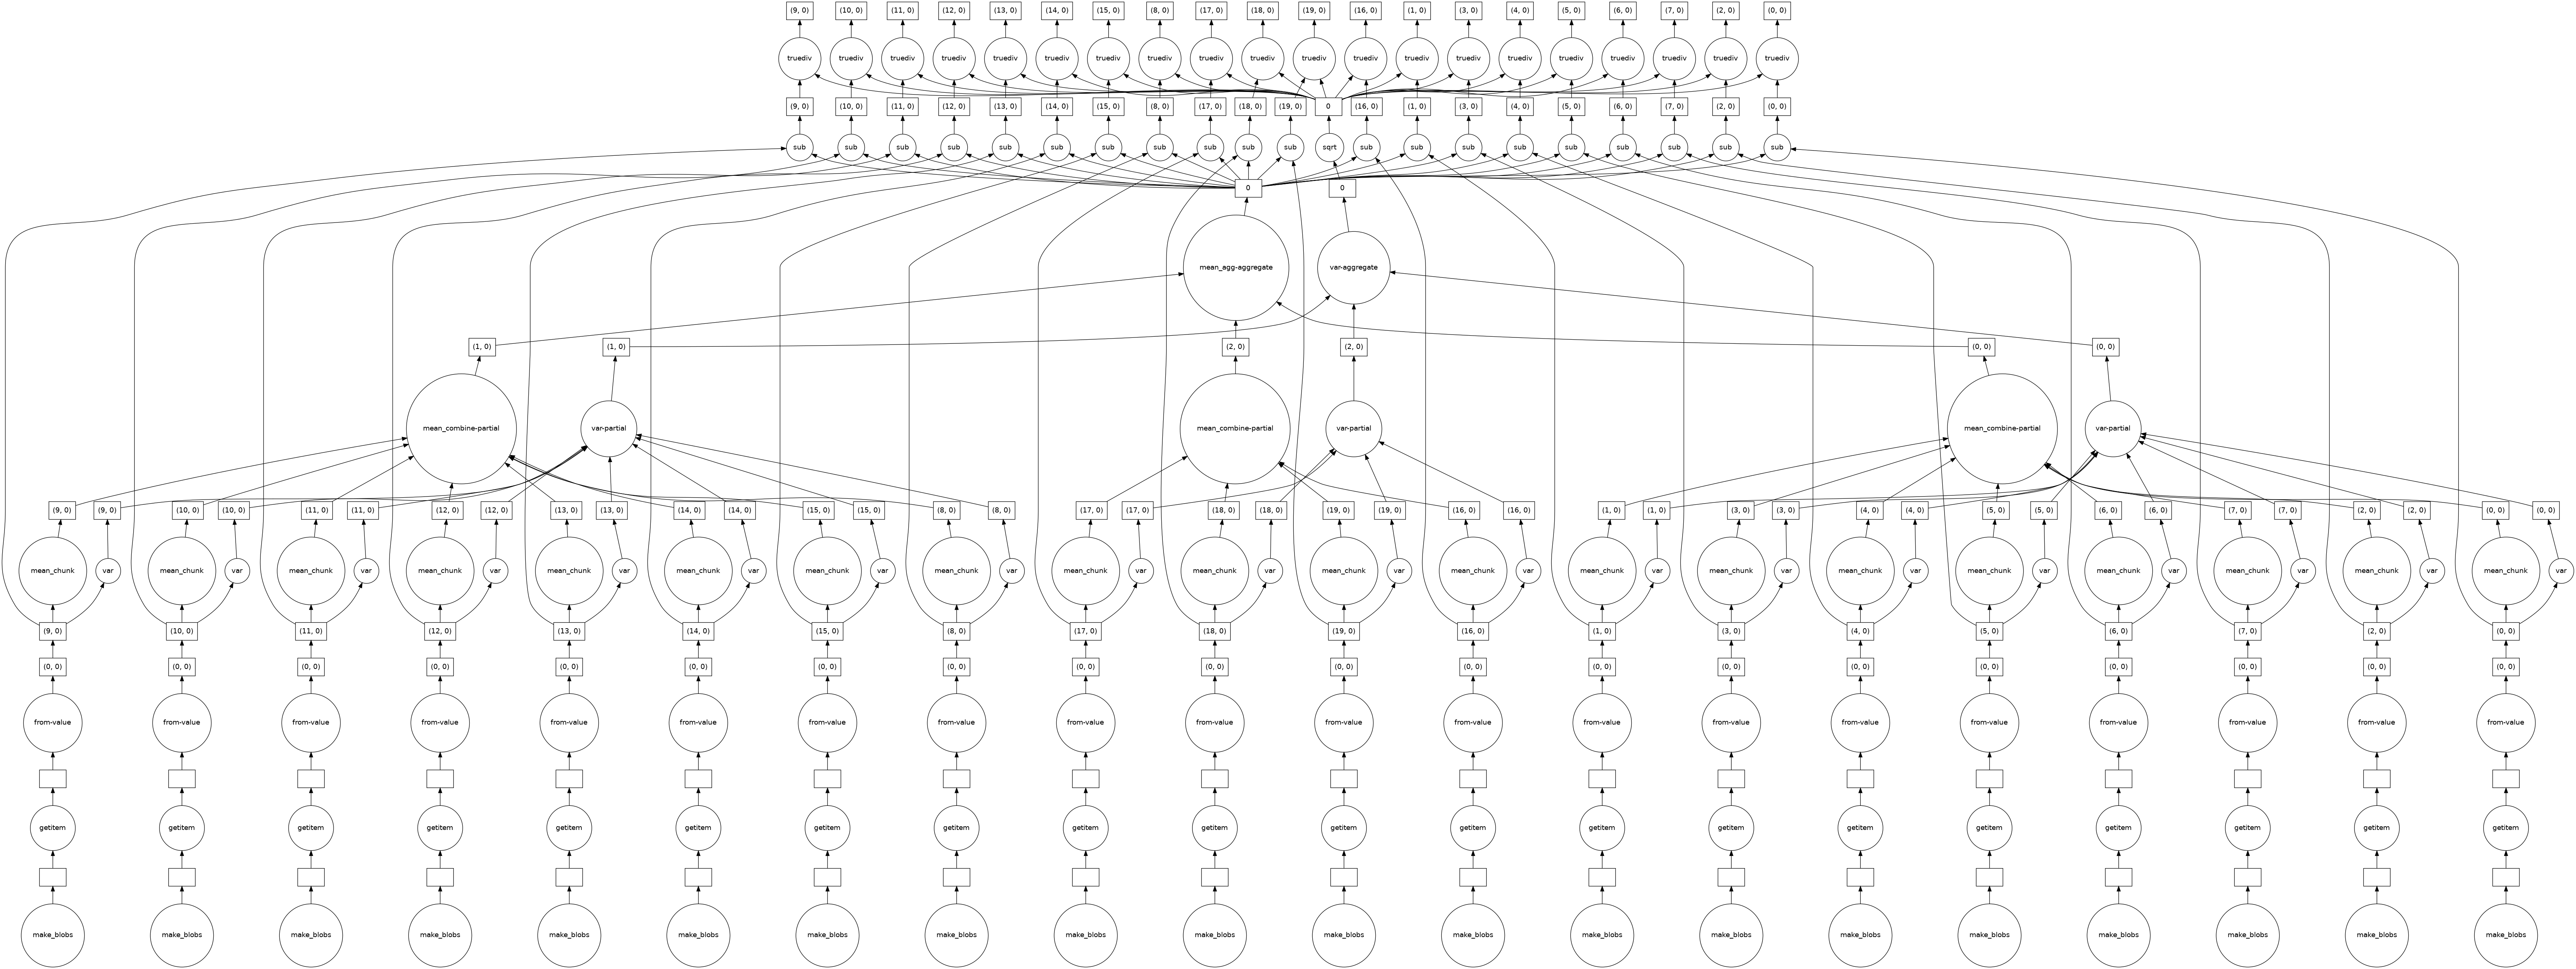

In [117]:
data_normalized.visualize()

In [118]:
data_normalized=data_normalized.persist() #Make data persistent to speed up future computation
data_normalized

dask.array<truediv, shape=(100000, 5000), dtype=float64, chunksize=(5242, 5000), chunktype=numpy.ndarray>

In [119]:
from dask.distributed import performance_report


#Our implementation
with performance_report(filename="kmean_our.html"):  
    %time synt_labels, synt_centroids = kmeans_parallel(X=data_normalized, k=k, l=2)


#Dask's implementation
%time dask_ml_kmeans = KMeans(n_clusters=k,init="k-means||", init_max_iter=100, oversampling_factor=2, random_state=42).fit(data_normalized)    
data_dask_centers = dask_ml_kmeans.cluster_centers_
data_dask_labels = dask_ml_kmeans.labels_

CPU times: user 1.09 s, sys: 96.5 ms, total: 1.18 s
Wall time: 15.6 s
CPU times: user 2.28 s, sys: 20.5 ms, total: 2.3 s
Wall time: 11.9 s


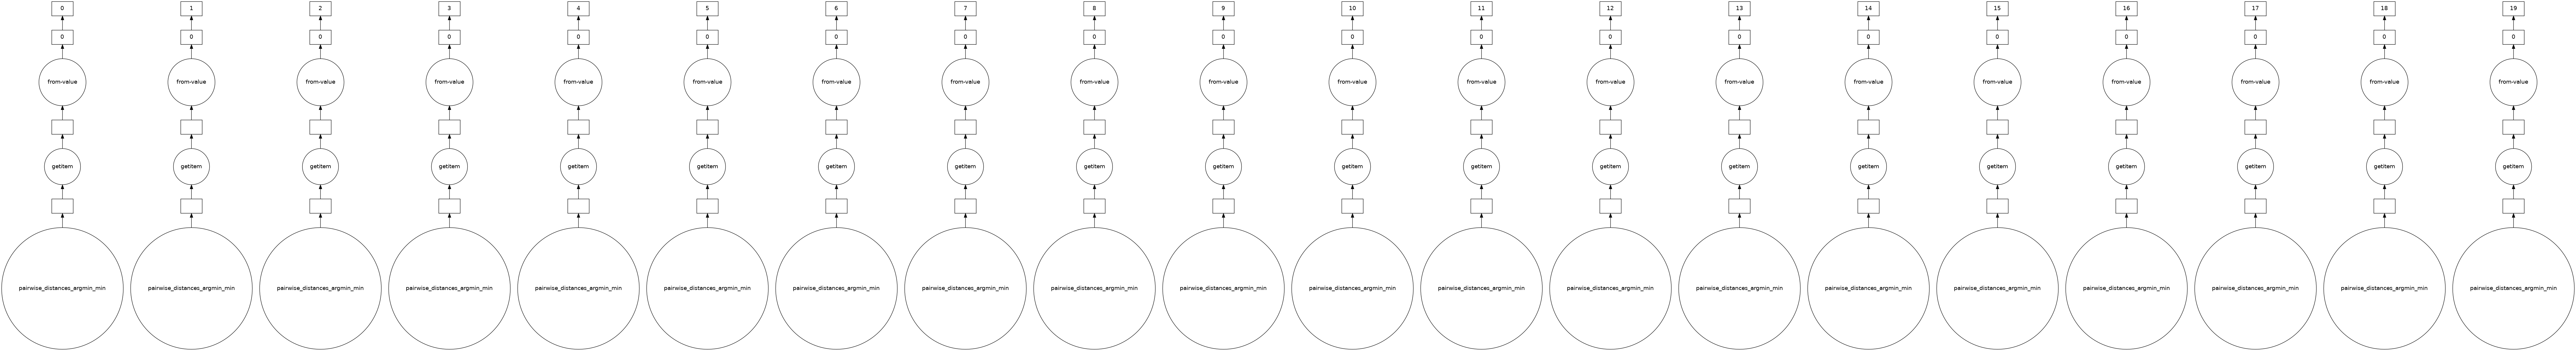

In [124]:
synt_labels.visualize()

In [125]:
#Plot

from IPython.display import IFrame
# Display the HTML report in Jupyter
IFrame(src="kmean_our.html", width=1280, height=720)

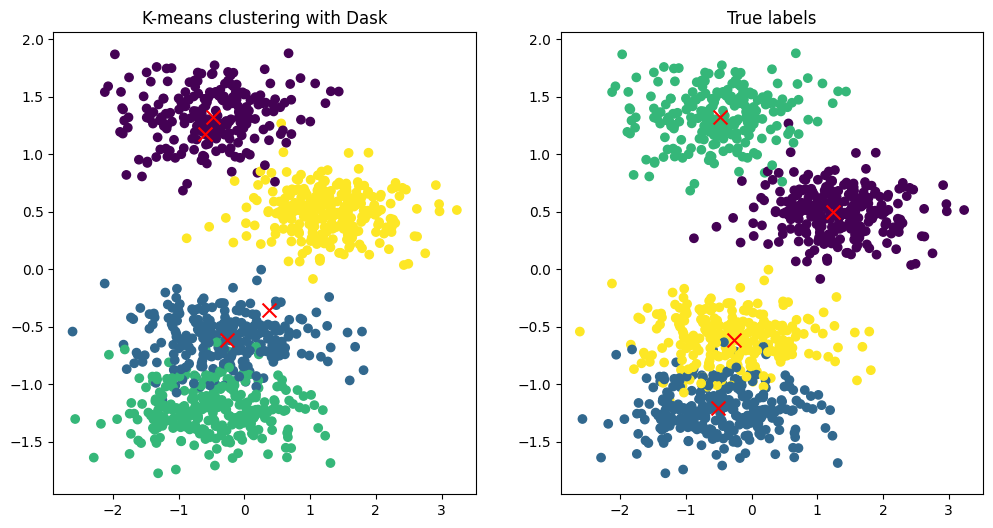

In [126]:
# Plotting a subset of the first 2 dim of the data 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

subset = int(data_normalized.shape[0]/100)

# Kmeans labels plot
ax[1].scatter(data_normalized[:subset, 0], data_normalized[:subset, 1], c=data_dask_labels[:subset], cmap='viridis')
ax[1].scatter(data_dask_centers[:, 0], data_dask_centers[:, 1], c='red', marker='x', s=100)
ax[1].set_title('True labels')


# True labels plot
ax[0].scatter(data_normalized[:subset, 0], data_normalized[:subset, 1], c=labels[:subset], cmap='viridis')
ax[0].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[0].set_title('K-means clustering with Dask')

plt.show()

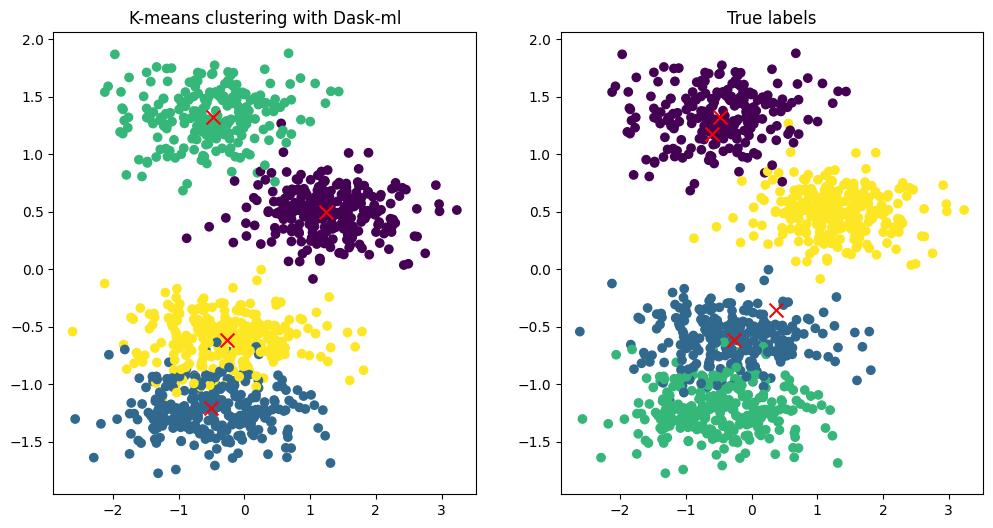

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot: K-means labels clustering with Dask-ml
ax[0].scatter(data_normalized[:subset, 0], data_normalized[:subset, 1], c=data_dask_labels[:subset], cmap='viridis')
ax[0].scatter(data_dask_centers[:, 0], data_dask_centers[:, 1], c='red', marker='x', s=100)
ax[0].set_title('K-means clustering with Dask-ml')

# Second plot: True labels
ax[1].scatter(data_normalized[:subset, 0], data_normalized[:subset, 1], c=labels[:subset], cmap='viridis')
ax[1].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[1].set_title('True labels')

plt.show()

In [128]:
# Define a function to sort centroids for consistency
def sort_centroids(centroids):
    # Use np.lexsort to sort the centroids by all dimensions
    sorted_indices = np.lexsort(centroids.T)
    return centroids[sorted_indices]

# Sort both sets of centroids
sorted_dask_centers = sort_centroids(data_dask_centers)
sorted_synt_centroids = sort_centroids(synt_centroids)

# Check for equality with np.allclose
equality = np.allclose(sorted_dask_centers, sorted_synt_centroids, atol=1e-10)
print(f"Equality between Dask-ML KMeans and Custom KMeans: {equality}")

Equality between Dask-ML KMeans and Custom KMeans: False


In [129]:
#here we will close the cluster because for the benchmarking we will need to create others cluster with differents configurations
# Shut down the Dask cluster, terminating all associated workers and releasing resources.
cluster.close()

# Close the connection between the Dask client and the cluster to ensure no further communication.
client.close()